-sandbox

<div style="text-align: center; line-height: 0; padding-top: 9px;">
  <img src="https://databricks.com/wp-content/uploads/2018/03/db-academy-rgb-1200px.png" alt="Databricks Learning" style="width: 600px">
</div>

# Distributed K-Means

- In this notebook, we are going to use **K-Means to cluster** our data. We will be using the Iris dataset, which has labels (the type of iris), but we will only use the labels to evaluate the model, not to train it. 

- At the end, we will look at how it is **implemented in the distributed setting.**

## ![Spark Logo Tiny](https://files.training.databricks.com/images/105/logo_spark_tiny.png) In this lesson you:<br>
 - **Build a K-Means model**
 - **Analyze the computation and communication of K-Means in a distributed setting**

In [0]:
from sklearn.datasets import load_iris
import pandas as pd

# Load in a Dataset from sklearn and convert to a Spark DataFrame
iris = load_iris()
iris_pd = pd.concat([pd.DataFrame(iris.data, columns=iris.feature_names), pd.DataFrame(iris.target, columns=["label"])], axis=1)
iris_df = spark.createDataFrame(iris_pd)
display(iris_df)

sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),label
5.1,3.5,1.4,0.2,0
4.9,3.0,1.4,0.2,0
4.7,3.2,1.3,0.2,0
4.6,3.1,1.5,0.2,0
5.0,3.6,1.4,0.2,0
5.4,3.9,1.7,0.4,0
4.6,3.4,1.4,0.3,0
5.0,3.4,1.5,0.2,0
4.4,2.9,1.4,0.2,0
4.9,3.1,1.5,0.1,0


Notice that we have four values as "features".  We'll reduce those down to two values (for visualization purposes) and convert them to a **`DenseVector`**.  To do that we'll use the **`VectorAssembler`**.

In [0]:
from pyspark.ml.feature import VectorAssembler

vec_assembler = VectorAssembler(inputCols=["sepal length (cm)", "sepal width (cm)"], outputCol="features")
iris_two_features_df = vec_assembler.transform(iris_df)
display(iris_two_features_df)

sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),label,features
5.1,3.5,1.4,0.2,0,"Map(vectorType -> dense, length -> 2, values -> List(5.1, 3.5))"
4.9,3.0,1.4,0.2,0,"Map(vectorType -> dense, length -> 2, values -> List(4.9, 3.0))"
4.7,3.2,1.3,0.2,0,"Map(vectorType -> dense, length -> 2, values -> List(4.7, 3.2))"
4.6,3.1,1.5,0.2,0,"Map(vectorType -> dense, length -> 2, values -> List(4.6, 3.1))"
5.0,3.6,1.4,0.2,0,"Map(vectorType -> dense, length -> 2, values -> List(5.0, 3.6))"
5.4,3.9,1.7,0.4,0,"Map(vectorType -> dense, length -> 2, values -> List(5.4, 3.9))"
4.6,3.4,1.4,0.3,0,"Map(vectorType -> dense, length -> 2, values -> List(4.6, 3.4))"
5.0,3.4,1.5,0.2,0,"Map(vectorType -> dense, length -> 2, values -> List(5.0, 3.4))"
4.4,2.9,1.4,0.2,0,"Map(vectorType -> dense, length -> 2, values -> List(4.4, 2.9))"
4.9,3.1,1.5,0.1,0,"Map(vectorType -> dense, length -> 2, values -> List(4.9, 3.1))"


In [0]:
from pyspark.ml.clustering import KMeans

kmeans = KMeans(k=3, seed=221, maxIter=20)

#  Call fit on the estimator and pass in iris_two_features_df
model = kmeans.fit(iris_two_features_df)

# Obtain the clusterCenters from the KMeansModel
centers = model.clusterCenters()

# Use the model to transform the DataFrame by adding cluster predictions
transformed_df = model.transform(iris_two_features_df)

print(centers)
print()
print()
display(transformed_df)

[array([5.00392157, 3.40980392]), array([5.8, 2.7]), array([6.82391304, 3.07826087])]

sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),label,features,prediction
5.1,3.5,1.4,0.2,0,"Map(vectorType -> dense, length -> 2, values -> List(5.1, 3.5))",0
4.9,3.0,1.4,0.2,0,"Map(vectorType -> dense, length -> 2, values -> List(4.9, 3.0))",0
4.7,3.2,1.3,0.2,0,"Map(vectorType -> dense, length -> 2, values -> List(4.7, 3.2))",0
4.6,3.1,1.5,0.2,0,"Map(vectorType -> dense, length -> 2, values -> List(4.6, 3.1))",0
5.0,3.6,1.4,0.2,0,"Map(vectorType -> dense, length -> 2, values -> List(5.0, 3.6))",0
5.4,3.9,1.7,0.4,0,"Map(vectorType -> dense, length -> 2, values -> List(5.4, 3.9))",0
4.6,3.4,1.4,0.3,0,"Map(vectorType -> dense, length -> 2, values -> List(4.6, 3.4))",0
5.0,3.4,1.5,0.2,0,"Map(vectorType -> dense, length -> 2, values -> List(5.0, 3.4))",0
4.4,2.9,1.4,0.2,0,"Map(vectorType -> dense, length -> 2, values -> List(4.4, 2.9))",0
4.9,3.1,1.5,0.1,0,"Map(vectorType -> dense, length -> 2, values -> List(4.9, 3.1))",0


In [0]:
model_centers = []
iterations = [0, 2, 4, 7, 10, 20]
for i in iterations:
    kmeans = KMeans(k=3, seed=221, maxIter=i)
    model = kmeans.fit(iris_two_features_df)
    model_centers.append(model.clusterCenters())   

In [0]:
print("model_centers:")
for centroids in model_centers:
    print(centroids)

model_centers:
[array([4.87017544, 3.44561404]), array([6.34146341, 3.03170732]), array([7.42727273, 2.88181818])]
[array([5.01403509, 3.3122807 ]), array([6.128 , 2.84533333]), array([7.28333333, 3.13333333])]
[array([5.01403509, 3.3122807 ]), array([6.03846154, 2.81076923]), array([7.07857143, 3.11071429])]
[array([5.01428571, 3.33571429]), array([5.97 , 2.785]), array([6.98529412, 3.07941176])]
[array([5.01428571, 3.33571429]), array([5.93090909, 2.75272727]), array([6.91025641, 3.08717949])]
[array([5.00392157, 3.40980392]), array([5.8, 2.7]), array([6.82391304, 3.07826087])]

Let's visualize how our clustering performed against the true labels of our data.

Remember: **K-means doesn't use the true labels when training, but we can use them to evaluate.** 

Here, the star marks the cluster center.

In [0]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np

def prepare_subplot(xticks, yticks, figsize=(10.5, 6), hideLabels=False, gridColor="#999999", gridWidth=1.0, subplots=(1, 1)):
    """Template for generating the plot layout."""
    fig, ax_list = plt.subplots(subplots[0], subplots[1], figsize=figsize, facecolor="white", 
                               edgecolor="white")
    if not isinstance(ax_list, np.ndarray):
        ax_list = np.array([ax_list])
    
    for ax in ax_list.flatten():
        ax.axes.tick_params(labelcolor="#999999", labelsize="10")
        for axis, ticks in [(ax.get_xaxis(), xticks), (ax.get_yaxis(), yticks)]:
            axis.set_ticks_position("none")
            axis.set_ticks(ticks)
            axis.label.set_color("#999999")
            if hideLabels: axis.set_ticklabels([])
        ax.grid(color=gridColor, linewidth=gridWidth, linestyle="-")
        map(lambda position: ax.spines[position].set_visible(False), ["bottom", "top", "left", "right"])
        
    if ax_list.size == 1:
        ax_list = ax_list[0]  # Just return a single axes object for a regular plot
    return fig, ax_list

(1.0, 0.4980392156862745, 0.0, 1.0)
(0.6, 0.6, 0.6, 1.0)
(0.8941176470588236, 0.10196078431372549, 0.10980392156862745, 1.0)
Out[9]:

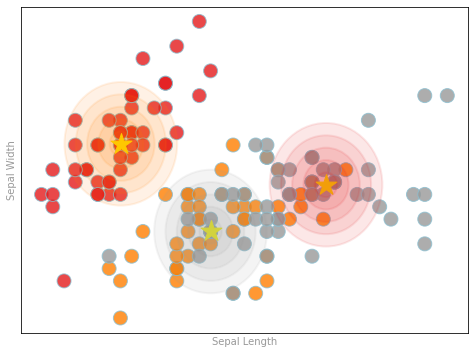

<Figure size 576x432 with 1 Axes>

In [0]:
data = iris_two_features_df.select("features", "label").collect()
features, labels = zip(*data)

x, y = zip(*features)
centers = model_centers[5]
centroid_x, centroid_y = zip(*centers)
color_map = "Set1"

fig, ax = prepare_subplot(np.arange(-1, 1.1, .4), np.arange(-1, 1.1, .4), figsize=(8,6))
plt.scatter(x, y, s=14**2, c=labels, edgecolors="#8cbfd0", alpha=0.80, cmap=color_map)
plt.scatter(centroid_x, centroid_y, s=22**2, marker="*", c="yellow")
cmap = cm.get_cmap(color_map)

color_index = [.5, .99, .0]
for i, (x,y) in enumerate(centers):
    print(cmap(color_index[i]))
    for size in [.10, .20, .30, .40, .50]:
        circle1=plt.Circle((x,y), size, color=cmap(color_index[i]), alpha=.10, linewidth=2)
        ax.add_artist(circle1)

ax.set_xlabel("Sepal Length"), ax.set_ylabel("Sepal Width")
fig

In addition to seeing the overlay of the clusters at each iteration, we can see how the cluster centers moved with each iteration (and what our results would have looked like if we used fewer iterations).

(1.0, 0.4980392156862745, 0.0, 1.0)
(0.6, 0.6, 0.6, 1.0)
(0.8941176470588236, 0.10196078431372549, 0.10980392156862745, 1.0)
(1.0, 0.4980392156862745, 0.0, 1.0)
(0.6, 0.6, 0.6, 1.0)
(0.8941176470588236, 0.10196078431372549, 0.10980392156862745, 1.0)
(1.0, 0.4980392156862745, 0.0, 1.0)
(0.6, 0.6, 0.6, 1.0)
(0.8941176470588236, 0.10196078431372549, 0.10980392156862745, 1.0)
(1.0, 0.4980392156862745, 0.0, 1.0)
(0.6, 0.6, 0.6, 1.0)
(0.8941176470588236, 0.10196078431372549, 0.10980392156862745, 1.0)
(1.0, 0.4980392156862745, 0.0, 1.0)
(0.6, 0.6, 0.6, 1.0)
(0.8941176470588236, 0.10196078431372549, 0.10980392156862745, 1.0)
(1.0, 0.4980392156862745, 0.0, 1.0)
(0.6, 0.6, 0.6, 1.0)
(0.8941176470588236, 0.10196078431372549, 0.10980392156862745, 1.0)
Out[10]:

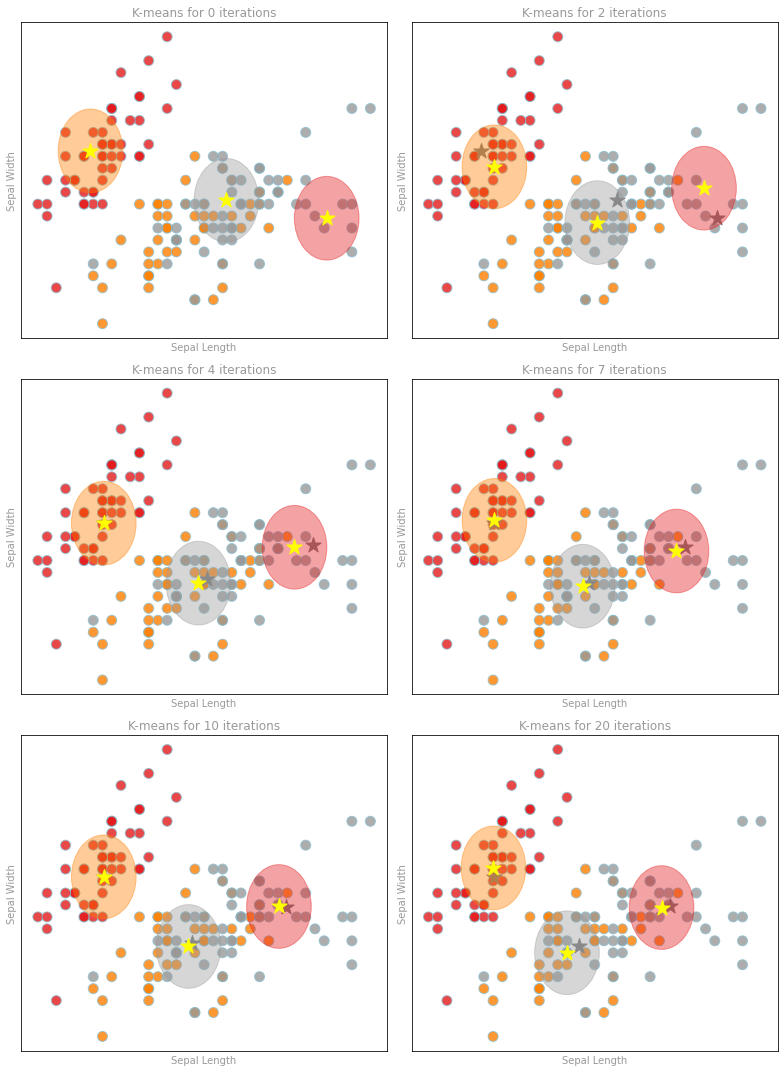

<Figure size 792x1080 with 6 Axes>

In [0]:
x, y = zip(*features)

old_centroid_x, old_centroid_y = None, None

fig, ax_list = prepare_subplot(np.arange(-1, 1.1, .4), np.arange(-1, 1.1, .4), figsize=(11, 15),
                             subplots=(3, 2))
ax_list = ax_list.flatten()

for i,ax in enumerate(ax_list[:]):
    ax.set_title("K-means for {0} iterations".format(iterations[i]), color="#999999")
    centroids = model_centers[i]
    centroid_x, centroid_y = zip(*centroids)
    
    ax.scatter(x, y, s=10**2, c=labels, edgecolors="#8cbfd0", alpha=0.80, cmap=color_map, zorder=0)
    ax.scatter(centroid_x, centroid_y, s=16**2, marker="*", c="yellow", zorder=2)
    if old_centroid_x and old_centroid_y:
      ax.scatter(old_centroid_x, old_centroid_y, s=16**2, marker="*", c="grey", zorder=1)
    cmap = cm.get_cmap(color_map)
    
    color_index = [.5, .99, 0.]
    for i, (x1,y1) in enumerate(centroids):
      print(cmap(color_index[i]))
      circle1=plt.Circle((x1,y1),.35,color=cmap(color_index[i]), alpha=.40)
      ax.add_artist(circle1)
    
    ax.set_xlabel("Sepal Length"), ax.set_ylabel("Sepal Width")
    old_centroid_x, old_centroid_y = centroid_x, centroid_y

plt.tight_layout()

fig

#### So let's take a look at what's happening here in the distributed setting.

<img src="https://files.training.databricks.com/images/Mapstage.png" height=200px>

<img src="https://files.training.databricks.com/images/Mapstage2.png" height=500px>

<img src="https://files.training.databricks.com/images/ReduceStage.png" height=500px>

<img src="https://files.training.databricks.com/images/Communication.png" height=500px>

## Take Aways

When designing/choosing distributed ML algorithms
* Communication is key!
* Consider your data/model dimensions & how much data you need.
* Data partitioning/organization is important.

-sandbox
&copy; 2022 Databricks, Inc. All rights reserved.<br/>
Apache, Apache Spark, Spark and the Spark logo are trademarks of the <a href="https://www.apache.org/">Apache Software Foundation</a>.<br/>
<br/>
<a href="https://databricks.com/privacy-policy">Privacy Policy</a> | <a href="https://databricks.com/terms-of-use">Terms of Use</a> | <a href="https://help.databricks.com/">Support</a>